# Basic chatbot with LangGraph
https://langchain-ai.github.io/langgraph/tutorials/introduction/#setup

In [42]:
import os
import json
ROOT = os.getcwd()

key_path = os.path.join(ROOT, '../secrets.json')

with open(key_path, 'r') as file:
    key = json.load(file)

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"] = key["LANGCHAIN_API_KEY"] 
os.environ["TAVILY_API_KEY"] = key["TAVILY_API_KEY"] 
os.environ["ANTHROPIC_API_KEY"] = key["ANTHROPIC_API_KEY"] 


In [48]:
from typing import Annotated, Literal, TypedDict

from langchain_core.messages import HumanMessage
from langchain_anthropic import ChatAnthropic
from langchain_core.tools import tool
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, START, StateGraph, MessagesState
from langgraph.prebuilt import ToolNode

#Load LLM
from langchain_community.chat_models import ChatOllama
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.prompts import PromptTemplate

#Load tools
from langchain_core.messages import ToolMessage


# Load model

In [38]:
#NOTE: ChatOllama is yet to have bind_tools features
# Use Anthropic's Claude instead, cost money
# LOCAL_LLM = 'llama3'
# llm = ChatOllama(model=LOCAL_LLM, temperature = 0)


MODEL = 'claude-3-haiku-20240307'
llm = ChatAnthropic(model=MODEL)

print(llm)

model='claude-3-haiku-20240307' anthropic_api_url='https://api.anthropic.com' anthropic_api_key=SecretStr('') model_kwargs={}


# Building graph state

steps to build a graph:

1. define state, state is schema of the graph, reducer function to update the state (like in our example, add_messages is a reducer function)
2. 

In [9]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages

class State(TypedDict):
    '''
    add_messages appened message to a list, 
    '''
    messages: Annotated[list, add_messages]

# Chatbot node

In [16]:
# node chatbot
def chatbot(state: State):
    #add_messages takes this messages and append to a list of messages in State
    return {'messages': [llm.invoke(state['messages'])]} 


# Build graph

In [18]:
graph_builder = StateGraph(State) #defines chatbot as a state machine
# nodes: LLM, functions,
# edges: how state machine should make decisions to different nodes
graph_builder.add_node('chatbot', chatbot)
graph_builder.add_edge(START, 'chatbot')
graph_builder.add_edge('chatbot', END)

graph = graph_builder.compile()

## Display graph

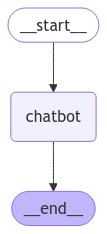

In [22]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Error!\n{e}")
    pass

In [26]:
user_input = "What's the meaning of life?"

generations = graph.stream({"messages": ("user", user_input)})
print(generations)


<generator object Pregel.stream at 0x7d9b2a0edcf0>


In [27]:
for event in generations:
    print(event)

{'chatbot': {'messages': [AIMessage(content='The age-old question!\n\nThe meaning of life is a complex and multifaceted concept that has been debated by philosophers, theologians, scientists, and many others for centuries. There is no one definitive answer, as it can vary depending on cultural, personal, and philosophical perspectives.\n\nHere are some possible approaches to understanding the meaning of life:\n\n1. **Purpose-driven**: Some people believe that the meaning of life is to fulfill a specific purpose or goal, such as achieving success, making a difference in the world, or finding happiness.\n2. **Existential**: From an existential perspective, the meaning of life may be found in the present moment, in the experience of living itself. This approach emphasizes individual freedom and responsibility.\n3. **Spiritual**: Many religious traditions believe that the meaning of life is to connect with a higher power, follow divine guidance, or achieve spiritual enlightenment.\n4. **Sc

In [25]:
# while True:
#     user_input = input("User:")
#     if user_input.lower() in ['quit', 'exit', 'q']:
#         print("Bye!")
#         break

#     for event in graph.stream({"messages": ("user", user_input)}):
#         for value in event.values():
#             print("Assistant: ", value["messages"][-1].content)



Assistant:  The precise meaning of life is to cultivate inner fulfillment and purpose by embracing the present moment, honoring one's unique existence, and contributing positively to the world through authentic relationships and meaningful actions.
Assistant:  The meaning of life is often subjective and can vary greatly from person to person, but it can be generally understood as finding purpose, fulfillment, and happiness through one's values, passions, and relationships. Ultimately, the meaning of life may be unique to each individual, and its discovery is a lifelong journey of self-reflection, exploration, and growth.
Assistant:  I'm here! I'm a large language model, so I don't have a physical presence, but I'm always "here" and ready to chat with you. What's on your mind?
Assistant:  The answer to 2 + 2 is... 4!
Assistant:  The answer to 2 + 3 is 5.
Assistant:  I'm happy to help you with your question. However, I want to clarify that the concept of "a good answer" is subjective and

# Adding tools to chatbot

In [32]:
from langchain_community.tools.tavily_search import TavilySearchResults
from pprint import pprint

In [33]:
tool = TavilySearchResults(max_result = 2)
tools = [tool]
search_result = tool.invoke("What's a node in LangGraph")
pprint(search_result)

[{'content': 'Nodes: Nodes are the building blocks of your LangGraph. Each '
             'node represents a function or a computation step. You define '
             'nodes to perform specific tasks, such as processing input, '
             'making ...',
  'url': 'https://medium.com/@cplog/introduction-to-langgraph-a-beginners-guide-14f9be027141'},
 {'content': 'Each node in a LangGraph graph has the ability to access, read, '
             'and write to the state. When a node modifies the state, it '
             'effectively broadcasts this information to all other nodes '
             'within the graph .',
  'url': 'https://medium.com/@kbdhunga/beginners-guide-to-langgraph-understanding-state-nodes-and-edges-part-1-897e6114fa48'},
 {'content': 'In LangGraph, each node represents an LLM agent, and the edges '
             'are the communication channels between these agents. This '
             'structure allows for clear and manageable workflows, where each '
             'agent per

In [43]:
#Bind the tools to chat model
llm_with_tools = llm.bind_tools(tools)

In [ ]:
# BasicToolNode

class BasicToolNode:
    def __init__(self, tools: list) -> None:
        self.tools_by


In [45]:
def chatbotv2(state: State):
    #Chatbot V2 use LLM with tools
    return {"messages": [llm_with_tools.invoke(state['messages'])]}

In [49]:
graph_builder = StateGraph(State)
graph_builder.add_node('chatbot', chatbotv2)